In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('data/mbajk.csv')
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-07-30 12:12:58+00:00,24.1,69,18.1,27.5,27.0,0.0,981.3,22,13
1,2023-09-11 20:14:06+00:00,19.2,85,16.6,20.9,0.0,0.0,981.7,22,0
2,2023-07-09 05:12:32+00:00,NaN,92,16.2,19.2,0.0,0.0,989.1,22,8
3,2023-07-21 12:37:13+00:00,NaN,64,17.2,27.2,94.0,0.0,978.8,22,14
4,2023-07-03 17:01:20+00:00,NaN,80,17.3,22.9,NaN,NaN,982.4,22,21


Sortiranje zapisov glede na čas zapisa

In [3]:
df['date'] = pd.to_datetime(df['date'])

df.sort_values(by=['date'], inplace=True)
df.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
11830,2023-06-25 19:07:30+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,8
5971,2023-06-25 19:33:48+00:00,21.5,55,12.1,21.7,0.0,0.0,984.4,22,7
23274,2023-06-25 19:45:44+00:00,21.5,55,12.1,21.7,0.0,0.0,984.4,22,6
9286,2023-06-25 19:55:29+00:00,21.5,55,12.1,21.7,0.0,NaN,984.4,22,8
22190,2023-06-25 20:02:16+00:00,21.5,55,12.1,21.7,NaN,0.0,984.4,22,12


Izris grafa vrednosti izposoje koles glede na čas

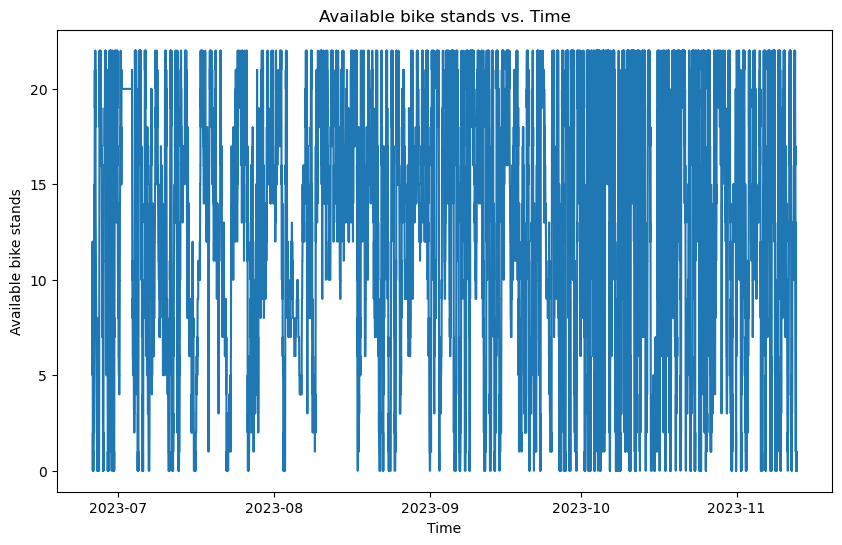

In [4]:
plt.figure(figsize=(10, 6))
plt.plot(df['date'], df['available_bike_stands'])
plt.xlabel('Time')
plt.ylabel('Available bike stands')
plt.title('Available bike stands vs. Time')
plt.show()

In [5]:
bike_stands = df['available_bike_stands']
bike_stands_array = bike_stands.values.reshape(-1, 1)

In [6]:
test_data_size = 1488

train_data, test_data = bike_stands_array[:-test_data_size],bike_stands_array[-test_data_size:]

In [7]:
scaler = MinMaxScaler()

train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

In [8]:
def sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        target = data[i + window_size]
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

In [9]:
window_size = 186
X_train, y_train = sliding_window(train_data, window_size)
X_test, y_test = sliding_window(test_data, window_size)

In [18]:
print(X_test.shape)


(1302, 1, 186)


In [10]:
# Preoblikovanje vhodnih učnih podatkov
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

# Preverjanje oblik
print(f"Oblika učnih podatkov: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Oblika testnih podatkov: X_test: {X_test.shape}, y_test: {y_test.shape}")

Oblika učnih podatkov: X_train: (25995, 1, 186), y_train: (25995, 1)
Oblika testnih podatkov: X_test: (1302, 1, 186), y_test: (1302, 1)


In [11]:
model_rnn = Sequential([
    SimpleRNN(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    SimpleRNN(32),
    Dense(16, activation='relu'),
    Dense(1)
], name="RNN")

model_gru = Sequential([
    GRU(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(1)
], name="GRU")

model_lstm = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
], name="LSTM")



In [12]:
models = [model_rnn, model_gru, model_lstm]
history = {}

In [13]:
for model in models:
    model.compile(optimizer='adam', loss='mean_squared_error')
    h = model.fit(X_train, y_train, epochs=50, batch_size=64, verbose=2)
    history[model.name] = h.history

Epoch 1/50


2023-12-13 23:17:46.021002: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


407/407 - 1s - loss: 0.0172 - 1s/epoch - 3ms/step
Epoch 2/50
407/407 - 0s - loss: 0.0073 - 403ms/epoch - 990us/step
Epoch 3/50
407/407 - 0s - loss: 0.0062 - 356ms/epoch - 874us/step
Epoch 4/50
407/407 - 1s - loss: 0.0055 - 656ms/epoch - 2ms/step
Epoch 5/50
407/407 - 0s - loss: 0.0053 - 377ms/epoch - 927us/step
Epoch 6/50
407/407 - 0s - loss: 0.0052 - 371ms/epoch - 912us/step
Epoch 7/50
407/407 - 0s - loss: 0.0048 - 317ms/epoch - 779us/step
Epoch 8/50
407/407 - 0s - loss: 0.0048 - 298ms/epoch - 732us/step
Epoch 9/50
407/407 - 0s - loss: 0.0047 - 318ms/epoch - 781us/step
Epoch 10/50
407/407 - 0s - loss: 0.0048 - 299ms/epoch - 734us/step
Epoch 11/50
407/407 - 0s - loss: 0.0045 - 297ms/epoch - 729us/step
Epoch 12/50
407/407 - 0s - loss: 0.0043 - 300ms/epoch - 738us/step
Epoch 13/50
407/407 - 0s - loss: 0.0046 - 341ms/epoch - 838us/step
Epoch 14/50
407/407 - 0s - loss: 0.0044 - 371ms/epoch - 911us/step
Epoch 15/50
407/407 - 0s - loss: 0.0044 - 421ms/epoch - 1ms/step
Epoch 16/50
407/407 - 0s

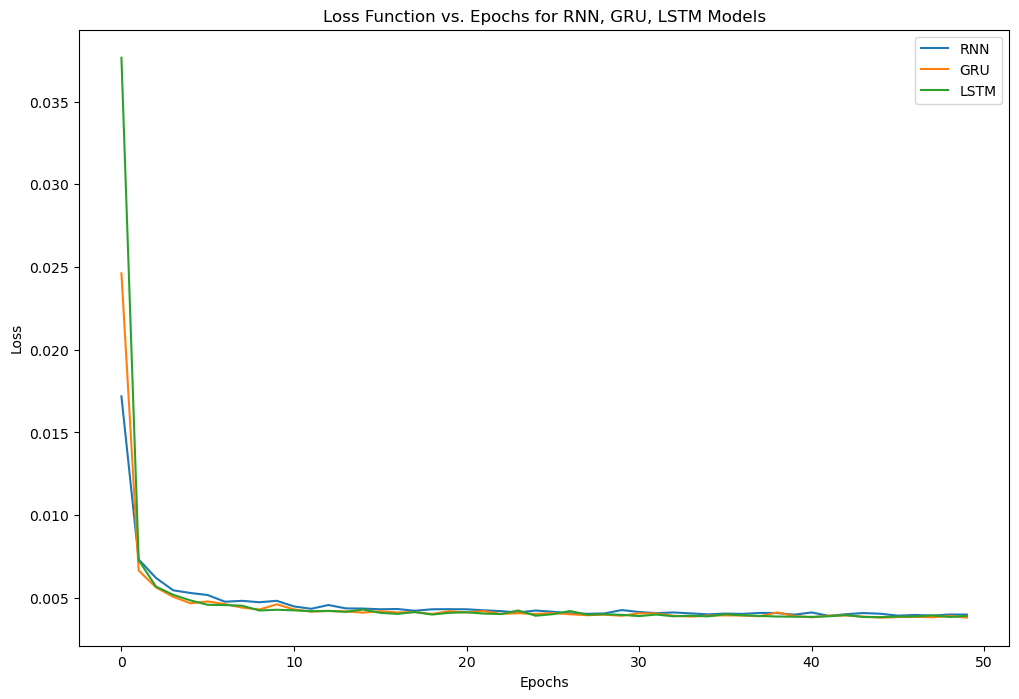

In [14]:
plt.figure(figsize=(12, 8))
for name, values in history.items():
    plt.plot(values['loss'], label=name)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs for RNN, GRU, LSTM Models')
plt.legend()
plt.show()

In [15]:
import pickle


with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
model_gru.save('model_gru.h5')

In [20]:
df.head(186)

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
11830,2023-06-25 19:07:30+00:00,24.2,43,10.9,23.3,0.0,0.0,984.5,22,8
5971,2023-06-25 19:33:48+00:00,21.5,55,12.1,21.7,0.0,0.0,984.4,22,7
23274,2023-06-25 19:45:44+00:00,21.5,55,12.1,21.7,0.0,0.0,984.4,22,6
9286,2023-06-25 19:55:29+00:00,21.5,55,12.1,21.7,0.0,NaN,984.4,22,8
22190,2023-06-25 20:02:16+00:00,21.5,55,12.1,21.7,NaN,0.0,984.4,22,12
...,...,...,...,...,...,...,...,...,...,...
1573,2023-06-27 05:12:44+00:00,19.0,81,15.6,19.9,41.0,0.0,982.1,22,11
24617,2023-06-27 05:24:18+00:00,19.0,81,15.6,19.9,41.0,0.0,982.1,22,15
1746,2023-06-27 05:27:46+00:00,19.0,81,15.6,19.9,41.0,0.0,982.1,22,17
23755,2023-06-27 05:34:19+00:00,20.7,83,17.7,22.7,65.0,0.0,982.5,22,22


In [16]:
results = {
    'MSE': [],
    'MAE': [],
    'EVS': []
}

y_test = scaler.inverse_transform(y_test)

for model in models:
    predicted = model.predict(X_test, verbose=0)
    predicted = scaler.inverse_transform(predicted)

    mse = mean_squared_error(y_test, predicted)
    mae = mean_absolute_error(y_test, predicted)
    evs = explained_variance_score(y_test, predicted)
    print(f'{model.name} - MSE: {mse:.2f}')
    print(f'{model.name} - MAE: {mae:.2f}')
    print(f'{model.name} - EVS: {evs:.2f}')
    print("-" * 20)
    results['MSE'].append((model.name, mse))
    results['MAE'].append((model.name, mae))
    results['EVS'].append((model.name, evs))

[[[0.86363636 1.         1.         ... 0.5        0.54545455 0.54545455]]

 [[1.         1.         1.         ... 0.54545455 0.54545455 0.54545455]]

 [[1.         1.         1.         ... 0.54545455 0.54545455 0.54545455]]

 ...

 [[0.27272727 0.27272727 0.31818182 ... 0.         0.         0.        ]]

 [[0.27272727 0.31818182 0.13636364 ... 0.         0.         0.        ]]

 [[0.31818182 0.13636364 0.18181818 ... 0.         0.         0.        ]]]
RNN - MSE: 2.80
RNN - MAE: 1.24
RNN - EVS: 0.95
--------------------
GRU - MSE: 2.65
GRU - MAE: 1.19
GRU - EVS: 0.95
--------------------
LSTM - MSE: 2.65
LSTM - MAE: 1.18
LSTM - EVS: 0.95
--------------------


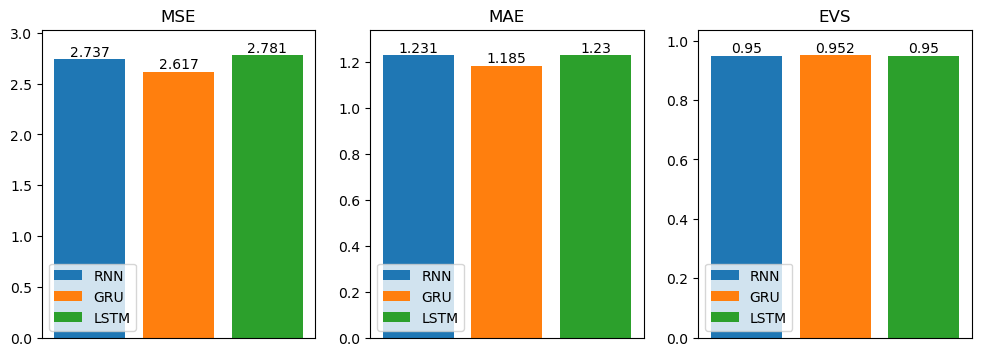

In [18]:
metrics = ['MSE', 'MAE', 'EVS']
model_names = [model.name for model in models]

width = 0.8
cols = len(metrics)

fig, axs = plt.subplots(1, cols, figsize=(12, 4))

for i, metric in enumerate(metrics):
    ax = axs[i]
    max = -float('inf')


    for j, model in enumerate(model_names):
        value = results[metric][j][1]
        if value > max:
          max = value
        ax.bar(j, value, width, label=model)
        ax.text(j, value, str(round(value, 3)), ha='center', va='bottom')


    ax.set_ylim([0, max * 1.09])
    ax.set_title(f'{metric}')
    ax.set_xticks([], [])
    ax.legend(loc='lower left')

plt.show()

In [19]:
dates = df['date'].values
print(dates)

['2023-06-25T19:07:30.000000000' '2023-06-25T19:33:48.000000000'
 '2023-06-25T19:45:44.000000000' ... '2023-11-12T23:34:21.000000000'
 '2023-11-12T23:44:27.000000000' '2023-11-12T23:54:32.000000000']


In [20]:
inverse_y_test = scaler.inverse_transform(y_test)
predictions = {}

for model in models:
    predicted = model.predict(X_test, verbose=0)
    predicted = scaler.inverse_transform(predicted)
    predictions[model.name] = predicted

In [21]:
output_dataframes = {}

for model in models:
    data = {
        'date': dates[-test_data_size + window_size:],
        'true': y_test.reshape(-1),
        'predicted': predictions[model.name].reshape(-1)
    }
    output_dataframes[model.name] = pd.DataFrame(data)

In [22]:
output_dataframes['RNN'].head()

,date,true,predicted
0,2023-11-07 05:49:07,12.0,12.893146
1,2023-11-07 05:52:30,12.0,12.461379
2,2023-11-07 05:58:13,14.0,12.536840
3,2023-11-07 06:02:42,16.0,14.097146
4,2023-11-07 06:08:58,17.0,16.041504


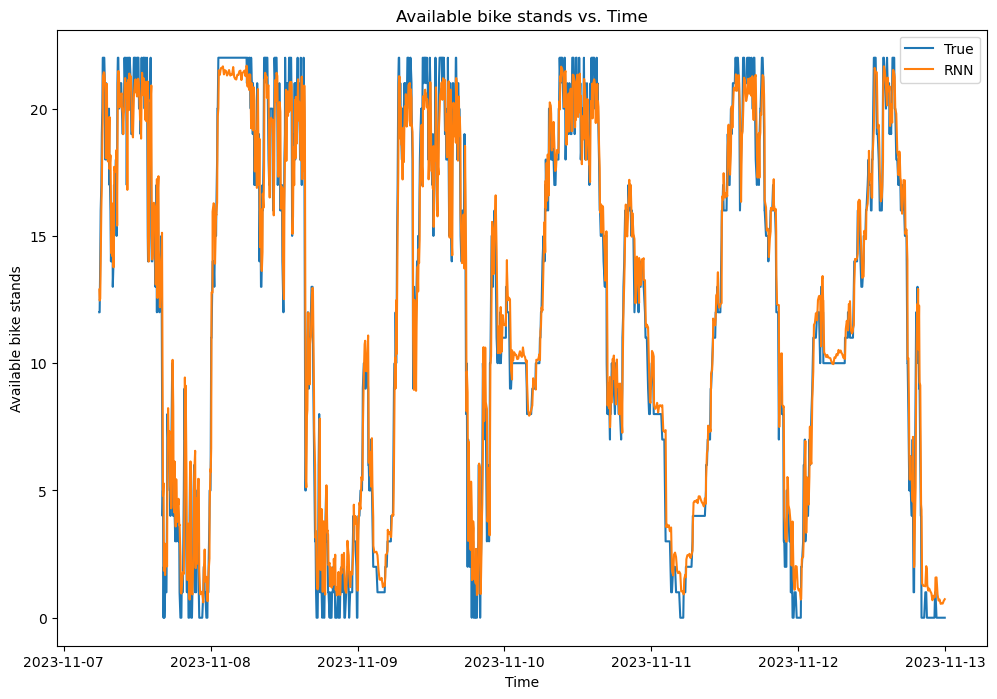

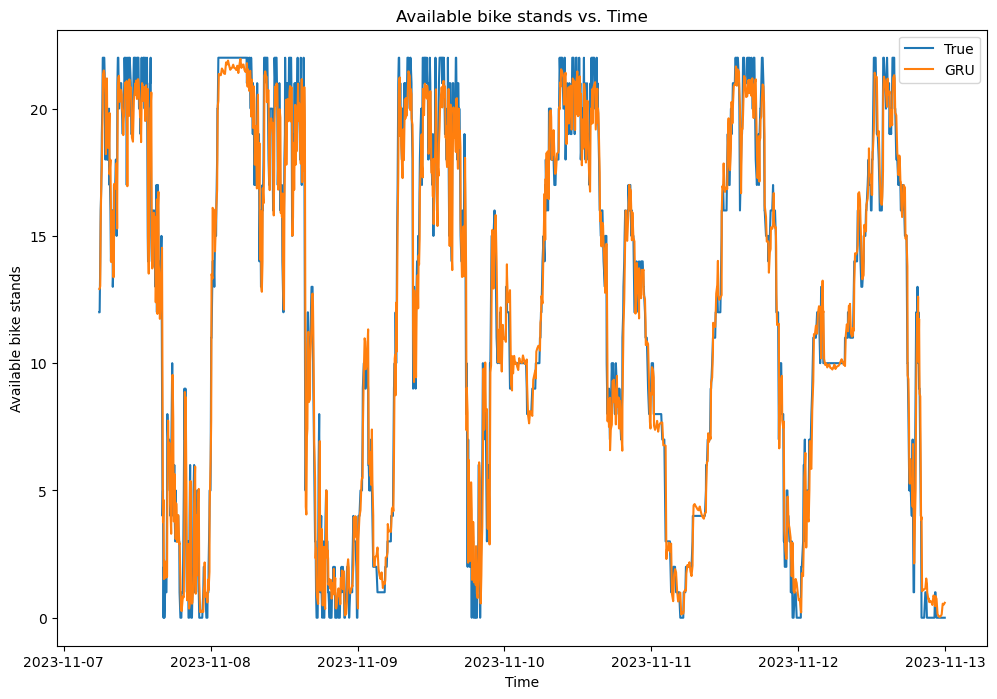

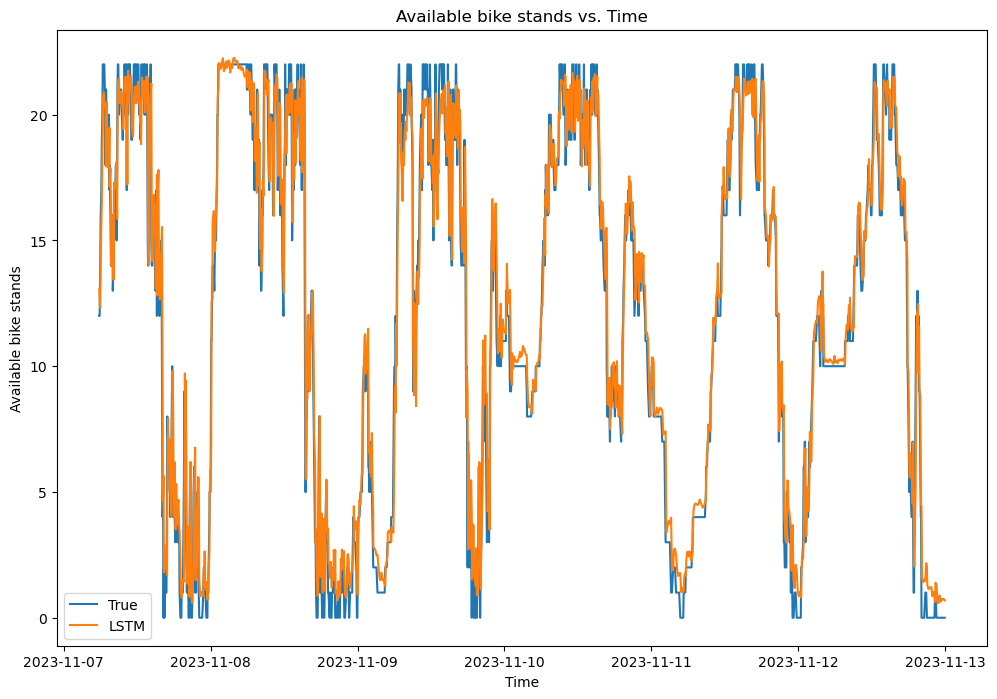

In [23]:
for model in models:
    output_df=output_dataframes[model.name]
    model_name = model.name
    plt.figure(figsize=(12, 8))
    plt.plot(output_df['date'], output_df['true'], label='True')
    plt.plot(output_df['date'],output_df['predicted'], label=model_name)
    plt.xlabel('Time')
    plt.ylabel('Available bike stands')
    plt.title('Available bike stands vs. Time')
    plt.legend()
    plt.show()

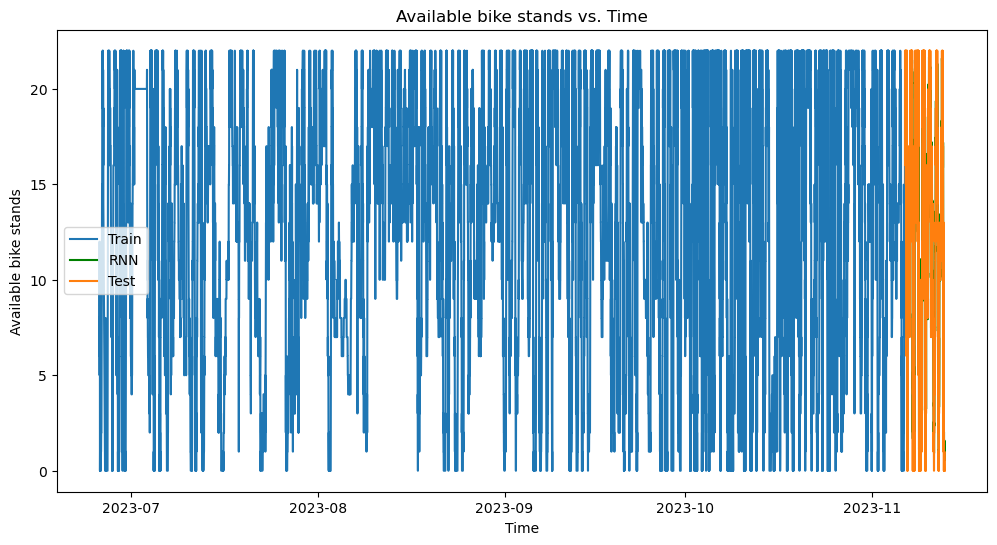

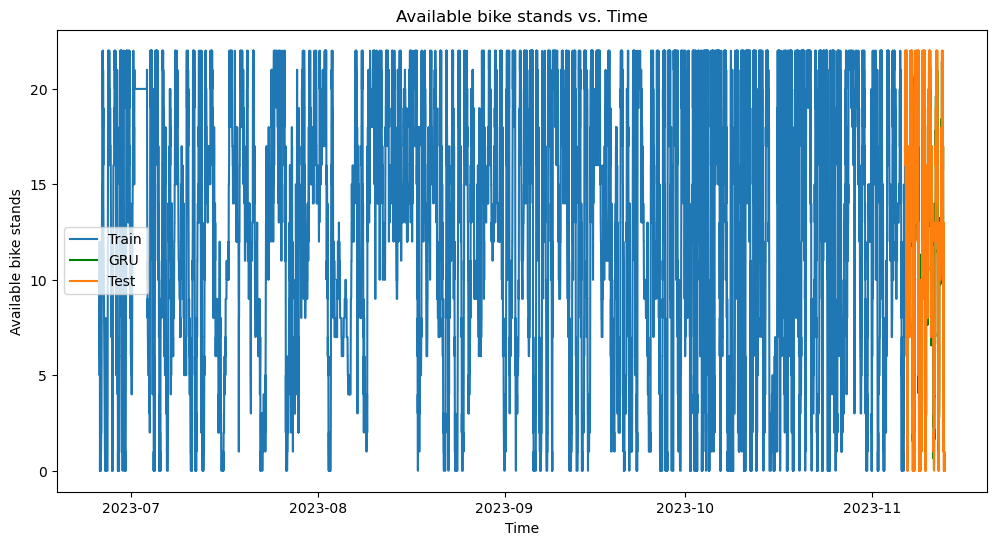

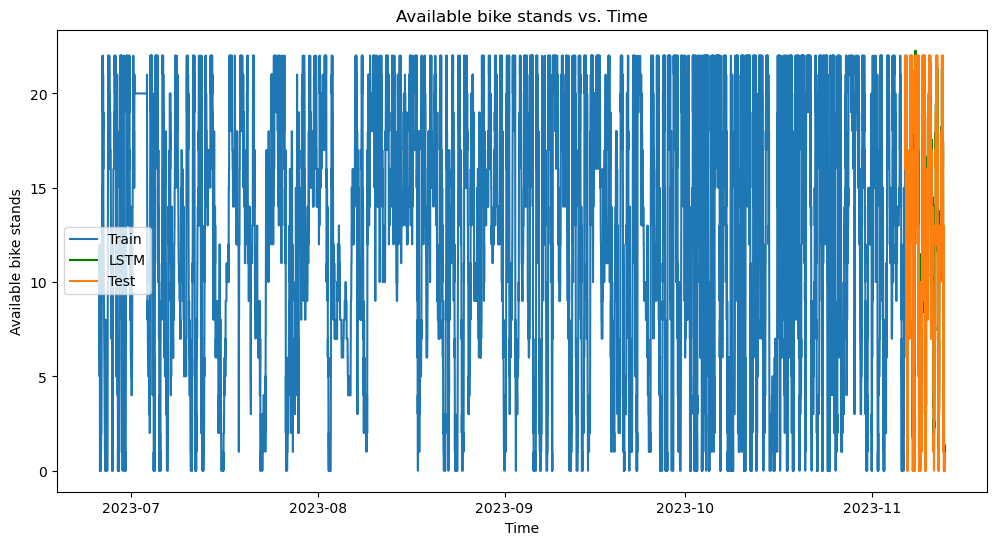

In [24]:
for model in models:
    model_df = output_dataframes[model.name]
    model_name = model.name
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'].iloc[:-test_data_size], df['available_bike_stands'].iloc[:-test_data_size], label='Train')
    plt.plot(model_df['date'], model_df['predicted'], label=model_name, color='green')
    plt.plot(df['date'].iloc[-test_data_size:], df['available_bike_stands'].iloc[-test_data_size:], label='Test')
    plt.xlabel('Time')
    plt.ylabel('Available bike stands')
    plt.title('Available bike stands vs. Time')
    plt.legend()
    plt.show()

In [25]:
df_bonus = pd.read_csv('data/mbajk.csv')
df_bonus.head()

,date,temperature,relative_humidity,dew_point,apparent_temperature,precipitation_probability,rain,surface_pressure,bike_stands,available_bike_stands
0,2023-07-30 12:12:58+00:00,24.1,69,18.1,27.5,27.0,0.0,981.3,22,13
1,2023-09-11 20:14:06+00:00,19.2,85,16.6,20.9,0.0,0.0,981.7,22,0
2,2023-07-09 05:12:32+00:00,NaN,92,16.2,19.2,0.0,0.0,989.1,22,8
3,2023-07-21 12:37:13+00:00,NaN,64,17.2,27.2,94.0,0.0,978.8,22,14
4,2023-07-03 17:01:20+00:00,NaN,80,17.3,22.9,NaN,NaN,982.4,22,21


In [26]:
df_bonus['date'] = pd.to_datetime(df_bonus['date'])
df_bonus.sort_values(by=['date'], inplace=True)

In [27]:
selected_features = ['available_bike_stands', 'apparent_temperature', 'dew_point', 'precipitation_probability', 'surface_pressure']

data = df_bonus[selected_features]
data.head()

,available_bike_stands,apparent_temperature,dew_point,precipitation_probability,surface_pressure
11830,8,23.3,10.9,0.0,984.5
5971,7,21.7,12.1,0.0,984.4
23274,6,21.7,12.1,0.0,984.4
9286,8,21.7,12.1,0.0,984.4
22190,12,21.7,12.1,NaN,984.4


In [29]:
from sklearn.ensemble import RandomForestRegressor

columns_with_missing = data.columns[data.isnull().any()].tolist()
for col in columns_with_missing:
    missing_indices = data[col].isnull()
    # Create features (X) and target variable (y)
    X = data.drop(columns=columns_with_missing)
    y = data[col]
    
    # Split into training and test sets
    X_train = X[~missing_indices]
    y_train = y[~missing_indices]
    X_test = X[missing_indices]
    
    # Initialize and train Random Forest Regressor
    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    
    # Predict missing values
    predicted_values = rf.predict(X_test)
    
    # Fill in missing values in the original DataFrame
    data.loc[missing_indices, col] = predicted_values


In [30]:
time_series = data.values


In [31]:
test_data_size = 1488
train_data, test_data = time_series[:-test_data_size], time_series[-test_data_size:]


In [32]:
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


In [33]:
def sliding_window_multi(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        target = data[i + window_size, 0]  # considering only 'available_bike_stands' as the target
        X.append(window)
        y.append(target)
    return np.array(X), np.array(y)

In [34]:
window_size = 186

# Generating train-test data with sliding window function
X_train_multi, y_train_multi = sliding_window_multi(train_data, window_size)
X_test_multi, y_test_multi = sliding_window_multi(test_data, window_size)

# Reshaping for RNN model
X_train_multi = X_train_multi.reshape(X_train_multi.shape[0], X_train_multi.shape[1], X_train_multi.shape[2])
X_test_multi = X_test_multi.reshape(X_test_multi.shape[0], X_test_multi.shape[1], X_test_multi.shape[2])

# Verifying shapes
print(f"Shape of training data: X_train: {X_train_multi.shape}, y_train: {y_train_multi.shape}")
print(f"Shape of testing data: X_test: {X_test_multi.shape}, y_test: {y_test_multi.shape}")

Shape of training data: X_train: (25995, 186, 5), y_train: (25995,)
Shape of testing data: X_test: (1302, 186, 5), y_test: (1302,)


In [35]:
model_rnn_multi = Sequential([
    SimpleRNN(32, return_sequences=True, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2])),
    SimpleRNN(32),
    Dense(16, activation='relu'),
    Dense(1)
], name="RNN")

model_gru_multi = Sequential([
    GRU(32, return_sequences=True, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2])),
    GRU(32),
    Dense(16, activation='relu'),
    Dense(1)
], name="GRU")

model_lstm_multi = Sequential([
    LSTM(32, return_sequences=True, input_shape=(X_train_multi.shape[1], X_train_multi.shape[2])),
    LSTM(32),
    Dense(16, activation='relu'),
    Dense(1)
], name="LSTM")

In [36]:
models_multi = [model_rnn_multi, model_gru_multi, model_lstm_multi]
history_multi = {}

In [37]:
print(np.any(np.isnan(X_train_multi)))
print(np.any(np.isnan(y_train_multi)))
print(np.any(np.isinf(X_train_multi)))
print(np.any(np.isinf(y_train_multi)))

False
False
False
False


In [38]:
for model in models_multi:
    model.compile(optimizer='adam', loss='mean_squared_error')
    history = model.fit(X_train_multi, y_train_multi, epochs=50, batch_size=64, verbose=1, validation_data=(X_test_multi, y_test_multi))
    history_multi[model.name] = history.history

Epoch 1/50
407/407 [==============================] - 14s 33ms/step - loss: 0.0075 - val_loss: 0.0060
Epoch 2/50
407/407 [==============================] - 13s 32ms/step - loss: 0.0042 - val_loss: 0.0061
Epoch 3/50
407/407 [==============================] - 13s 32ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 4/50
407/407 [==============================] - 13s 32ms/step - loss: 0.0041 - val_loss: 0.0059
Epoch 5/50
407/407 [==============================] - 14s 34ms/step - loss: 0.0041 - val_loss: 0.0058
Epoch 6/50
407/407 [==============================] - 13s 33ms/step - loss: 0.0041 - val_loss: 0.0057
Epoch 7/50
407/407 [==============================] - 13s 32ms/step - loss: 0.0041 - val_loss: 0.0060
Epoch 8/50
407/407 [==============================] - 13s 32ms/step - loss: 0.0041 - val_loss: 0.0061
Epoch 9/50
407/407 [==============================] - 13s 32ms/step - loss: 0.0040 - val_loss: 0.0059
Epoch 10/50
407/407 [==============================] - 13s 32ms/step - loss: 0.004

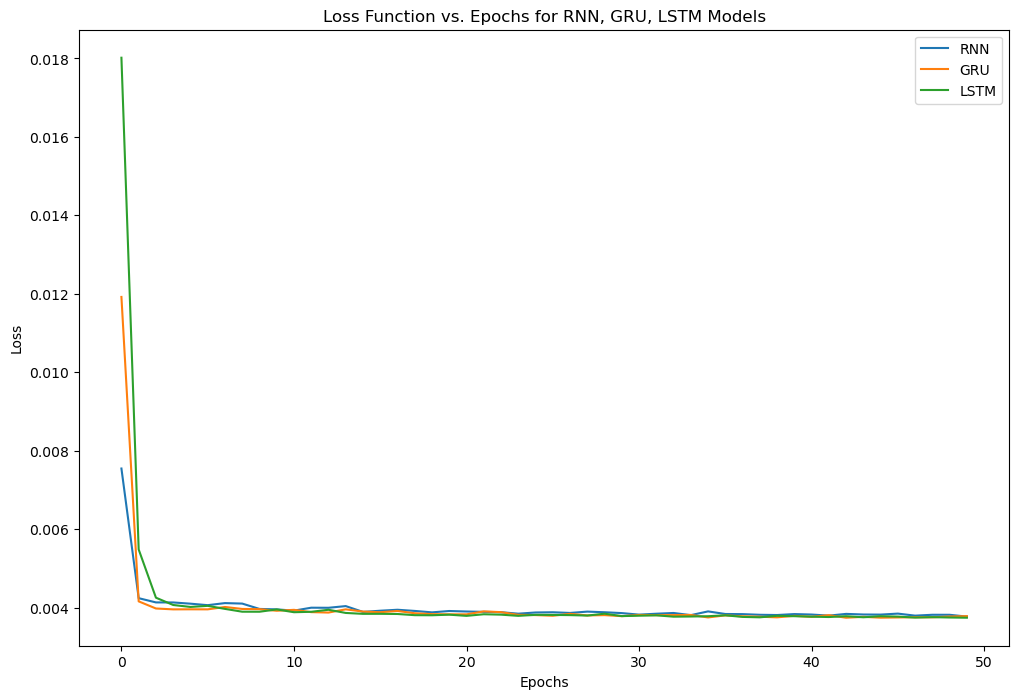

In [39]:
plt.figure(figsize=(12, 8))
for name, values in history_multi.items():
    plt.plot(values['loss'], label=name)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function vs. Epochs for RNN, GRU, LSTM Models')
plt.legend()
plt.show()

In [40]:
results_multi = {
    'MSE': [],
    'MAE': [],
    'EVS': []
}


In [50]:
X_train_multi_reshaped = np.swapaxes(X_train_multi, 1, 2)
X_test_multi_reshaped = np.swapaxes(X_test_multi, 1, 2)

# Shapes after reshaping
print(f"Preoblikovani X_train: {X_train_multi_reshaped.shape}")
print(f"Preoblikovani X_test: {X_test_multi_reshaped.shape}")

Preoblikovani X_train: (25995, 5, 186)
Preoblikovani X_test: (1302, 5, 186)


In [55]:
# vsaka značilnica svoj skaler

ValueError: Expected 2D array, got 1D array instead:
array=[0.54545455 0.54545455 0.63636364 ... 0.         0.         0.        ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.